# Lecture 8 – Dimensionality Reduction

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

### Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Curse of dimensionality

* Our minds can only really perceive objects and concepts in 3 or 4 dimensions

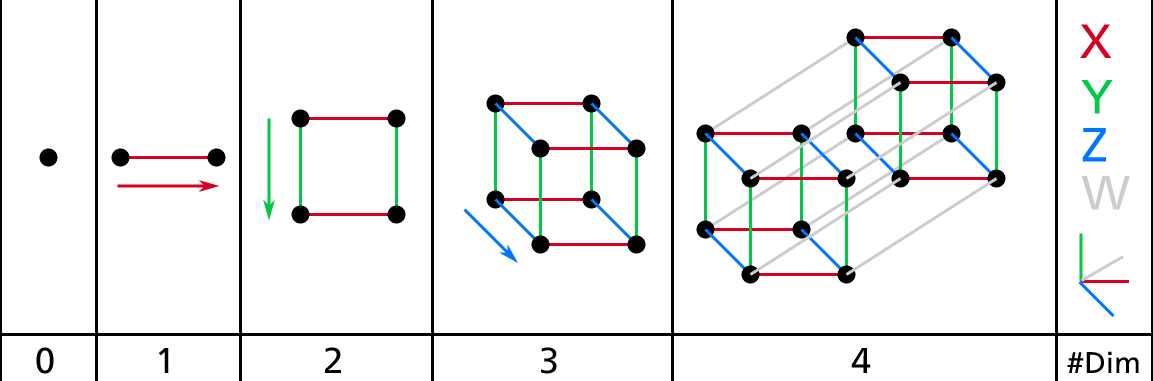

* High dimensional spaces are quite different from what you imagine it to be.

  * Choose a random point uniformly in a unit squre. Close to a boarder less than 0.001, with a 0.4% chance. (Random points are unlikely to be "extreme".)

  * Choose a random point uniformly in a unit hyper-cube in 10,000 dimensional space. Close to a boarder less than 0.001, with a 99.999999% chance.

* Another example.

  * Pick two points randomly in a unit square. The distance between these two points will be, on average, roughly 0.52.

  * Pick two points randomly in a unit cube. The distance between these two points will be, on average, roughly 0.66.

  * Pick two points randomly in a 1,000,000-dim hypercube. The distance between these two points will be, on average, roughly 408.

* Why?

* Lot of freedom in high dimensions. As a result, high-dimensional datasets are at risk of being very sparse: most training
instances are likely to be far away from each other.

* The curse of dimensionality: for the randomly distributed points to be close to each other, you need exponentially many points.

* If we need the training examples to be within 0.1 of each other on average, with 100 features (remember MNIST has 784 features) how many examples do I need in my training set? 
  * Ans: More than the number of atoms in the visible universe.


* So, if possible, we want to work in a low-dimensional space. 

* MNIST has a fixed dimension 784. 
  * Q. Is there a way to reduce the dimension?


## Main approaches for dimensionality reduction
* Projection
* Manifold learning

Let's build a simple 3D dataset:

In [ ]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### Projection

* In most real-world problems, training instances are not spread out uniformly across all dimensions. 
  * Many features are almost constant
  * Many others are highly correlated
* As a result, all training instances lie within (or close
to) a much lower-dimensional subspace.



A 3D dataset lying close to a 2D subspace:

In [ ]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])





Plot the 3D dataset, the plane and the projections on that plane.

Saving figure dataset_3d_plot


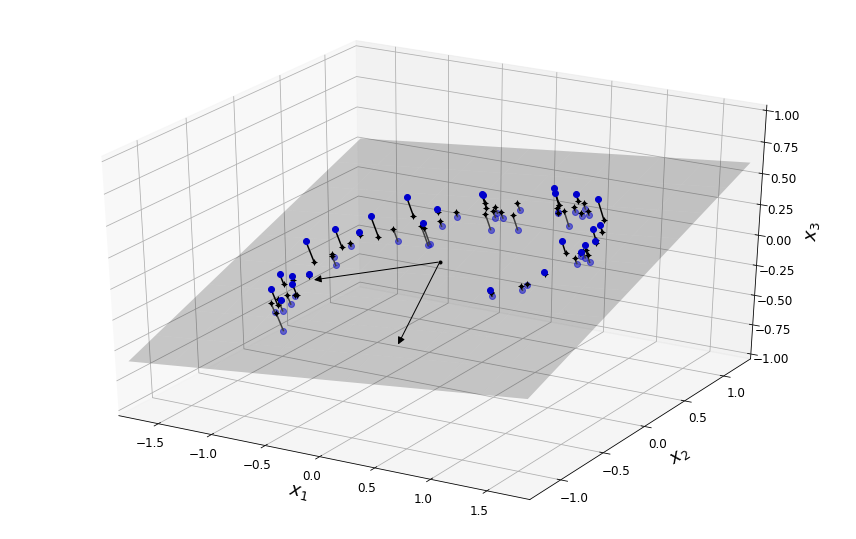

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(2*6, 2*3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

* Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space.
* If we project every training instance perpendicularly onto this subspace, we get the new 2D dataset.

* The new 2D dataset after projection:

Saving figure dataset_2d_plot


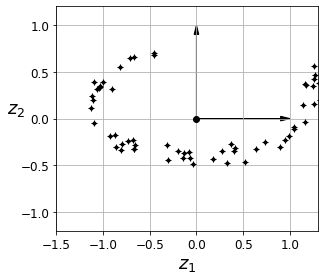

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

### Manifold learning

* Projection is not always the best approach to dimensionality reduction. 
* Especially when the subspace is not flat and is twisted and entangled.

* Example: Swiss roll dataset:

In [ ]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


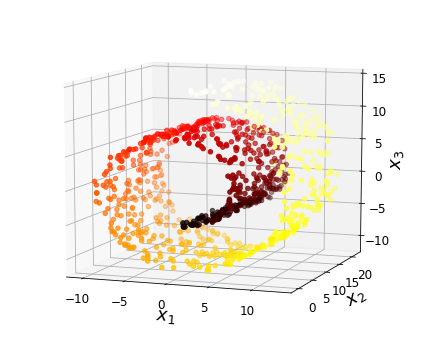

In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

* Imagine these are fossil examples from very old times (red) to more recent times (yellow).
* Q. What would happen if you project the data onto a horizontal plane (i.e., PCA)? 

* Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right):

Saving figure squished_swiss_roll_plot


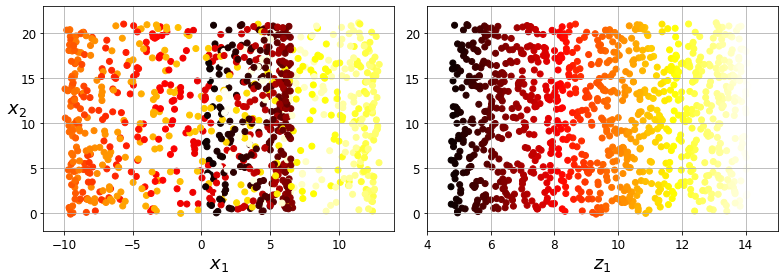

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

* What is a manifold?
  * Mathematical defs  
  * Roughly speaking, it's a surface
* The Swiss roll is an example of a 2D manifold. 
* A 2D manifold is a 2D surface that can be bent and twisted in a higher-dimensional space. 
* More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane.
  *  In the case of the Swiss roll, d = 2 and n = 3
  * It locally resembles a 2D plane, but it is rolled and twised.


* Manifold learning
  * Is a dimensionality reduction algorithm.
  * It models the manifold on which the training instances lie.

* Manifold assumption/hypothesis:
  * Most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.
  * This assumption is very often empirically observed.

MNIST dataset: all handwritten digit images have some
similarities. They are made of connected lines, the borders are white, and they are
more or less centered. If you randomly generated images, only a ridiculously tiny
fraction of them would look like handwritten digits. In other words, the degrees of
freedom available to you if you try to create a digit image are dramatically lower than
the degrees of freedom you would have if you were allowed to generate any image
you wanted. These constraints tend to squeeze the dataset into a lower-dimensional
manifold.

* Q. If we "unroll" the manifold and reduce the data dimension, will it make classification or regression easier?

* Manifold assumption alone is not sufficient.
  * Decision boundary also has to be low-dimensional, so to speak.

* Unhelpful and helpful cases:

Saving figure manifold_decision_boundary_plot1


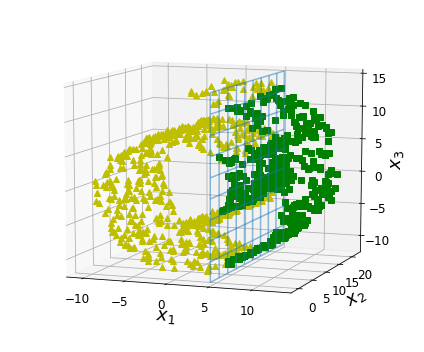

Saving figure manifold_decision_boundary_plot2


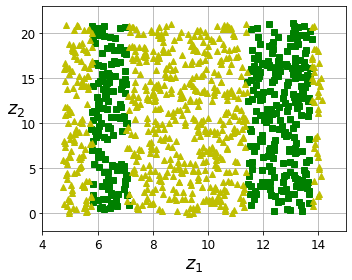

Saving figure manifold_decision_boundary_plot3


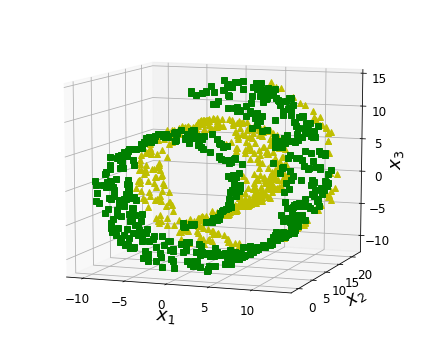

Saving figure manifold_decision_boundary_plot4


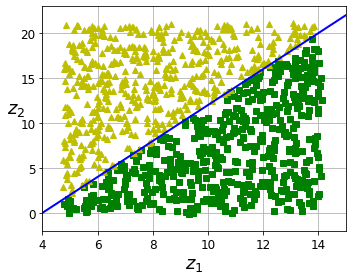

In [ ]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

## Principal Component Analysis (PCA)

* Arguably by far the most popular and straightforward dimensionality reduction algorithm.

### Preserving the Variance

* To project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane. 




Saving figure pca_best_projection_plot


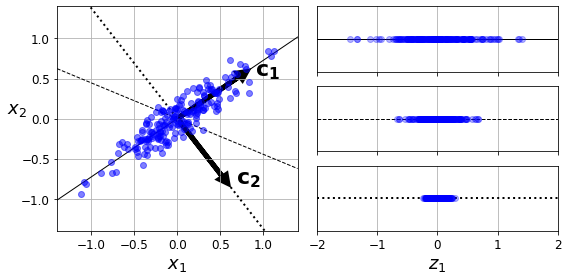

In [ ]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

* For example, a simple 2D dataset is represented above, along with three different axes (i.e., 1D hyperplanes).

* On the right is the result of the projection of the dataset onto each of these axes. 
  * The projection onto the solid line preserves the maximum variance.
  * The projection onto the dotted line preserves very little variance.
  * The projection onto the dashed line preserves an intermediate amount of variance.


* It seems reasonable to select the axis that preserves the maximum amount of variance
  * It will most likely lose less information than the other projections. 
  
* Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. 

* This is the rather simple idea behind PCA.

### Principal Components

* PCA identifies the first axis that accounts for the largest amount of variance in the training set. 
* It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. 

* In a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on.


* The i-th axis is called the i-th principal component (PC) of the data. 
  * The first PC is the axis on which vector c1 lies
  * The second PC is the axis on which vector c2 lies. 

* PCs are eigenvectors of the covariance matrix (optional).
  * Let $C:=Cov(x)=\frac{1}{N}(X-\mu)^T (X - \mu)$.
  * A PC $v\neq 0$ is $ C v = \lambda v$ for some $\lambda$.
  * Can be computed by Singular Value Decomposition.

In [ ]:
# (Optional)
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### (Also optional) Projecting Down to d Dimensions

In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [ ]:
X2D_using_svd = X2D

### Using Scikit-Learn

* With Scikit-Learn, PCA is easy to use.

* It also moves the data so that the data is centered at the origin.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[-0.89608814, -0.02615763],
       [-0.04536034,  0.18594886],
       [ 0.13835917,  0.03116662],
       [ 0.04163158,  0.06043718],
       [ 0.02185837,  0.04587267]])

In [ ]:
X2D_using_svd[:5]

array([[-0.89608814,  0.02615763],
       [-0.04536034, -0.18594886],
       [ 0.13835917, -0.03116662],
       [ 0.04163158, -0.06043718],
       [ 0.02185837, -0.04587267]])

* Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [ ]:
np.allclose(X2D, -X2D_using_svd)

False

* Recover the 3D points projected on the plane (PCA 2D subspace).

In [ ]:
X3D_inv = pca.inverse_transform(X2D)

* Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [ ]:
np.allclose(X3D_inv, X)

True

* We can compute the reconstruction error:

In [ ]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

2.897434430474253e-32

* The inverse transform in the SVD approach looks like this:

In [ ]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

* The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [ ]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

* The `PCA` object gives access to the principal components that it computed:

In [ ]:
pca.components_

array([[-0.79644131, -0.60471583],
       [ 0.60471583, -0.79644131]])

* Compare to the first two principal components computed using the SVD method:

In [ ]:
Vt[:2]

array([[-0.79644131, -0.60471583],
       [-0.60471583,  0.79644131]])

* Notice how the axes are flipped.

### Explained Variance Ratio

* Now let's look at the explained variance ratio:

In [ ]:
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

* The first dimension explains 84.2% of the variance, while the second explains 14.6%.

* By projecting down to 2D, we lost about 1.1% of the variance:

In [ ]:
1 - pca.explained_variance_ratio_.sum()

0.0

### MNIST example

* Q. What do MNIST principal components look like?

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
#d = np.argmax(cumsum >= 0.95) + 1

(784, 784)


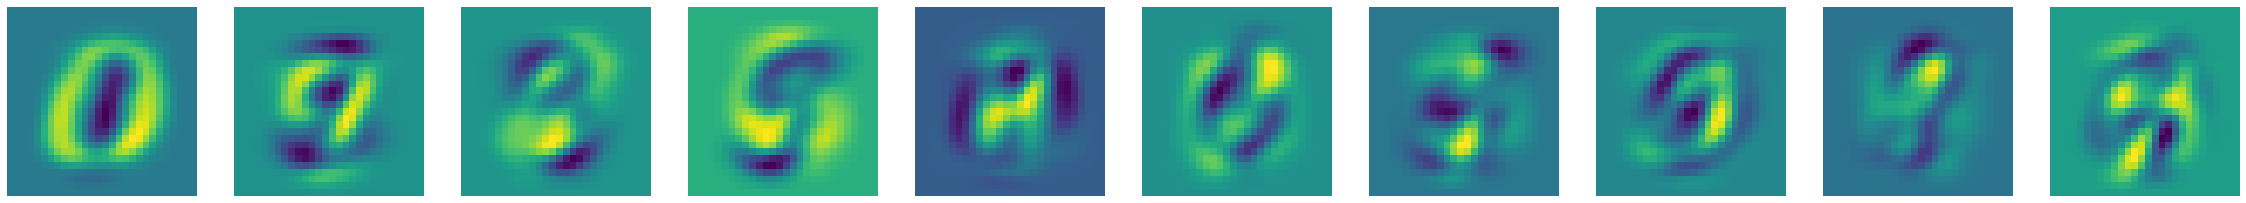

In [ ]:
print(pca.components_.shape)

f,axs = plt.subplots(1,10,figsize=(40,40))

for i in range(10):
  axs[i].imshow(pca.components_[i,:].reshape(28,28))
  axs[i].axis('off')

* Interpretation: these are main "modes" or "directions" along which the digit images vary.
* The PCs don't necessarily have to look like any particular digits, but they are main modes for all digits combined.

* Q. How many PCs do we need to retain the most of the variance in MNIST?

* Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

* Explained variance as a function of the number of dimensions:

Saving figure explained_variance_plot


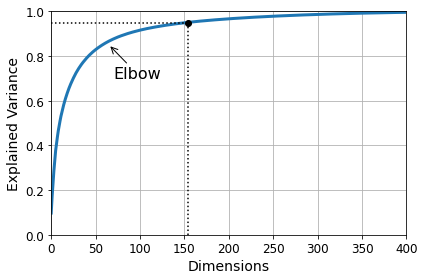

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

* Suppose we want the smallest number of dimensions/components that can still explain 95% of the variance. 
* Scikit-learn has that function.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

In [ ]:
d

154

In [ ]:
np.square(s) / np.square(s).sum()

array([0.95369864, 0.04630136])

Q. What does d=154 that mean? 

In [ ]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## PCA for Compression

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

* Original data X: N x 784
* Reduced data: N x 154
* Dataset (storage) has been reduced by a factor 154/784 ~= 20% !
* Cannot directly display the compressed data, and we need to recover the original shape by "pca.inverse_transform"

* Recovered data: N x 784

* MNIST compression that preserves 95% of the variance:

Saving figure mnist_compression_plot


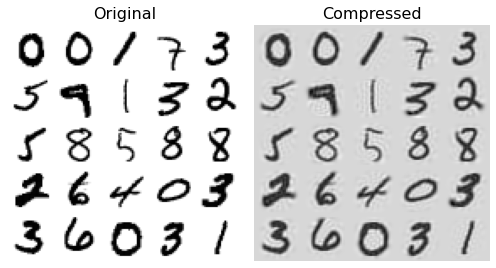

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

* Q. JPEG ? 

In [ ]:
X_reduced_pca = X_reduced

### Randomized PCA

* Let $m$ = number of samples, $n$ = dimension of data (e.g., 784)
* SVD can be very slow: $O(m × n^2) + O(n^3)$
* Just to get the first $d$ components fast, use Ramdomize PCA: $O(m × d^2) + O(d^3)$

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

Q. Related questions. Even if the time complexity is okay, what if you don't have enough memory to store the whole $X$ or the covariance matrix? 

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

* Let's check that compression still works well:

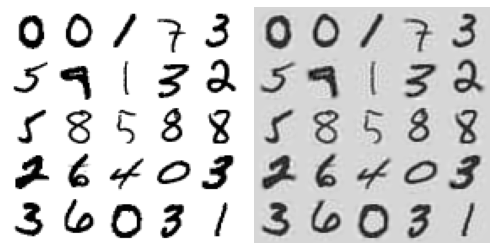

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [ ]:
X_reduced_inc_pca = X_reduced

* Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [ ]:
np.allclose(pca.mean_, inc_pca.mean_)

True

* But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [ ]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

* (Optional) Using `memmap()`:

* Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [ ]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

* Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [ ]:
del X_mm

* Next, another program would load the data and use it for training:

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

(End of Optional)


* Time complexity of PCA vs Randomized PCA vs Incremental PCA
  * Different number of PC
  * Different number of examples
  * Different number of features (=dimensions)

* Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [ ]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 13.8 seconds
    Inc PCA: 27.0 seconds
    Rnd PCA: 2.8 seconds
n_components = 10
    PCA: 10.7 seconds
    Inc PCA: 22.3 seconds
    Rnd PCA: 3.2 seconds
n_components = 154
    PCA: 11.9 seconds
    Inc PCA: 33.3 seconds
    Rnd PCA: 9.9 seconds


* Now let's systematically compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

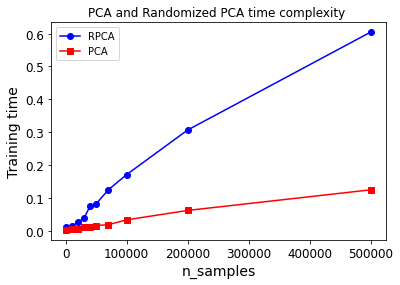

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

* Let's fix the the training set size this time.
* Let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

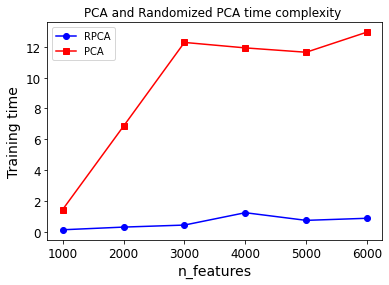

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## Kernel PCA

* PCA projections are orthogonal projections.
* That is, data is compressed only linearly.
* Q. Is there any method to do nonlinear compression?

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

* Swiss roll reduced to 2D using kPCA with various kernels:

Saving figure kernel_pca_plot


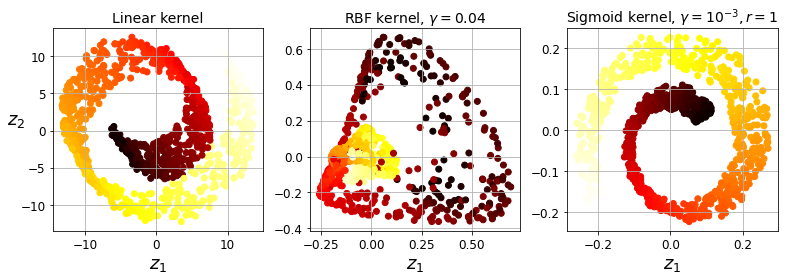

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

* Kernel PCA and the reconstruction pre-image error:

Saving figure preimage_plot


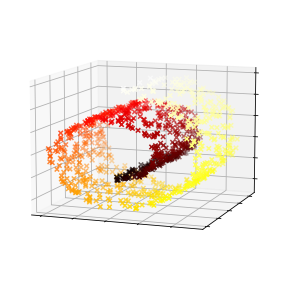

In [ ]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

* The reconstruction looks pretty good. 

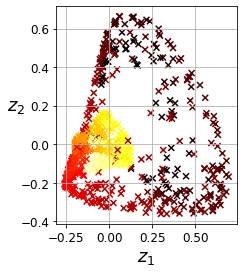

In [ ]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

* Summary of the kernel PCA

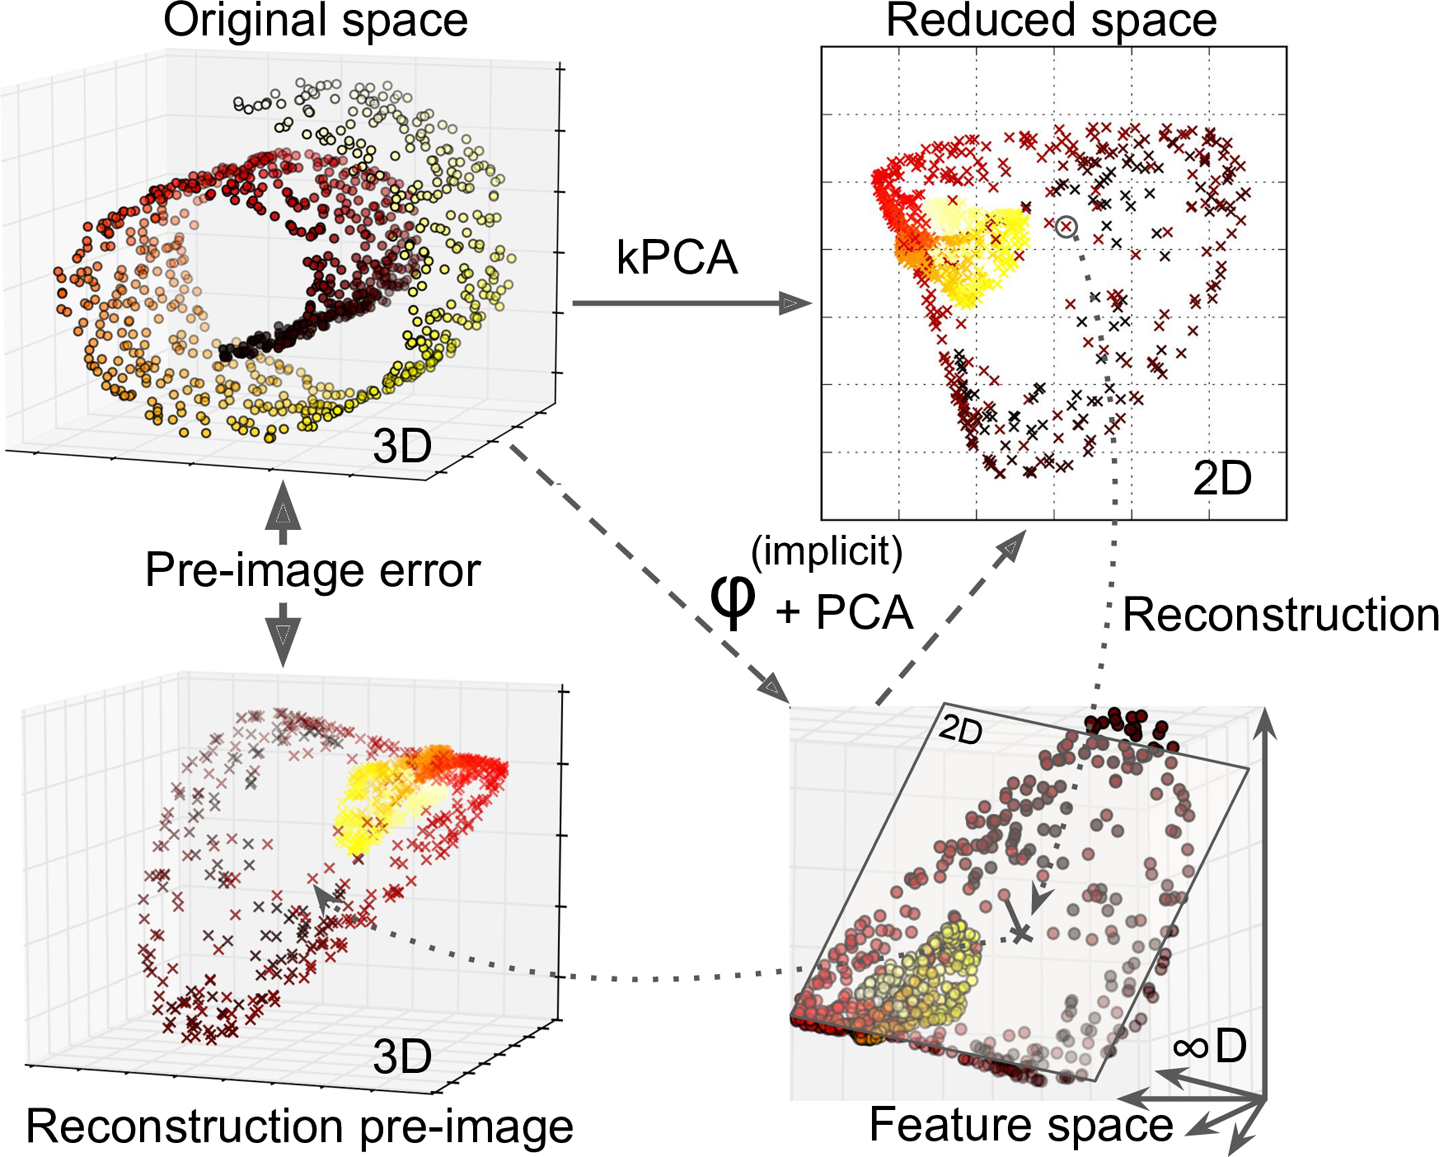

### Selecting a Kernel and Tuning Hyperparameters

* Q. What is a good set of hyperparameters for dimensionality reduction?

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

## !!!! GridSearchCV !!!!
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [ ]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

1.4326103121600706e-26

## Manifold Learning

* There have been efforts in the field to achieve nonlinear compression like kernel PCA, but genuinely disentangle complex datasets and find the nonlinear structure of data.


### LLE (Locally Linear Embedding)

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

* Unrolled Swiss roll using LLE:

Saving figure lle_unrolling_plot


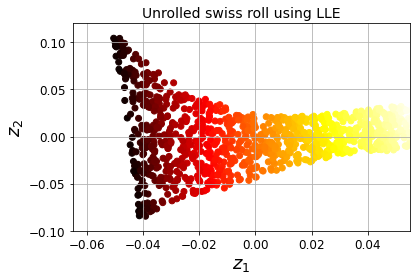

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

### MDS (Multidimensional Scaling)

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

## Isomap (Isometric Map)

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

## t-SNE (t-distributed Sstochastic Neighbor Embedding)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

## LDA (Linear Discriminant Anaysis)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

* Comparison of various dimensionality reduction techniques to reduce the Swill roll to 2D:

Saving figure other_dim_reduction_plot


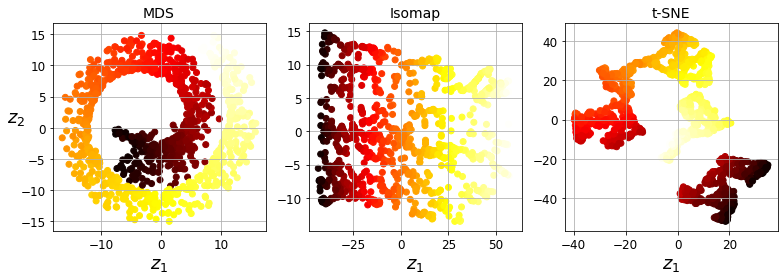

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()